In [1]:
## All-Weather

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수
from quant_functions import anal_funcs, data_funcs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [3]:
## 그리기 설정값
color_basic = "#3b4a6b" # 네이비 기본색
color_norm = "#f23557" # 진홍색 강조색
color_cont = "#22b2da" # 청록 대비색
color_cont2 = "#0095d9" # 짙은 청색
color_cont3 = "#6a5acd" # 선명한 보라색
color_cont4 = "#c77dff" # 라벤더
color_sub = "#ff6f3c" # 주황색 보조색
color_around = "#6E6E6E" # 회색 주변색
color_around2 = "#E0E0E0" # 밝은 회색 주변색

figsize=(12, 8)

In [4]:
# 블루 - 퍼플 테마
colors = [color_cont, color_cont2, color_cont3, color_cont4]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

## Func

In [5]:
class PortfolioAllocator(object):
    def __init__(self) -> None:
        print("STEP1: dataload => eg. df = dataload('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC')")
        print("STEP2: cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)")
        print("eg. process, obtimal, min_risk = cal_optimal(df)")
        pass
    
    def dataload(self, *ticker):        
        ## 올웨더용 자산군 데이터
        df = data_funcs.get_merged_df(*ticker)
        df = df[list(ticker)]
        return df
    
    # target_sum을 만족하는 0 이상 k개 숫자의 모든 순열을 찾는 함수
    def permutations_k_sum(self, n, k, target_sum, prefix=[]):
        # 종료조건: k개의 숫자를 모두 선택했을 때, 합이 target_sum이면 prefix를 반환
        if k == 0:
            if target_sum == 0:
                return [prefix]  # prefix 리스트가 유효한 조합이므로 반환
            return []  # target_sum이 0이 아니라면 빈 리스트 반환
        if n < 0:
            return []  # 탐색 시작점이 음수인 경우 빈 리스트 반환
        if target_sum < 0:
            return []  # target_sum이 음수일 경우 빈 리스트 반환

        permutations = []  # 가능한 순열을 저장할 리스트

        # 숫자 i를 선택해 재귀적으로 다음 숫자들을 선택
        for i in range(n+1):
            # n부터 i를 선택하여 target_sum-i를 새로운 target으로 설정하고, prefix에 선택된 i를 추가
            permutations += self.permutations_k_sum(n, k-1, target_sum - i, prefix + [i])
        
        # 최종적으로 가능한 모든 순열을 반환
        return permutations
    
    ## 리벨런싱을 반영한 포트폴리오 구성 시뮬레이션 함수
    def cal_rebalancing(self, df, ratio=[0.5, 0.5], rebalancing=None, unit=None):
        # 주어진 데이터프레임(df)을 복사하여 작업을 수행
        new_df = df.copy()
        df_dict = []  # 리벨런싱 시점별 데이터프레임을 저장할 리스트
        years = sorted(new_df.index.year.unique())  # 유일한 연도 리스트
        months = sorted(new_df.index.month.unique())  # 유일한 월 리스트

        # 월 단위 리벨런싱을 수행할 때 일자 조정 (월간 집계로 인한 계산 오류 방지)
        if (rebalancing == 'm') & (unit == 'monthly'):
            temp_df = new_df.copy()
            temp_df.index = temp_df.index - dt.timedelta(days=1)  # 인덱스를 하루 전으로 조정
            new_df = pd.concat([new_df, temp_df])  # 수정된 데이터프레임을 기존 데이터와 결합
            new_df = new_df.sort_index()  # 인덱스를 기준으로 정렬
            new_df = new_df.shift(-1).dropna()  # 데이터 이동 및 결측값 제거

        # 리벨런싱 주기에 따라 데이터프레임을 분할
        if rebalancing == 'm':  # 월별 리벨런싱
            for year in years:
                for month in months:
                    temp = new_df[(new_df.index.year == year) & (new_df.index.month == month)]
                    if len(temp) > 0:
                        df_dict.append(temp)  # 각 월에 해당하는 데이터프레임 추가

        elif rebalancing == 'y':  # 연별 리벨런싱
            for year in years:
                temp = new_df[(new_df.index.year == year)]
                if len(temp) > 0:
                    df_dict.append(temp)  # 각 연도에 해당하는 데이터프레임 추가
        else:
            df_dict.append(new_df)  # 리벨런싱이 없으면 전체 데이터프레임을 추가

        # 리벨런싱을 적용하여 전략 가치 계산
        prev_val = 1  # 이전 리벨런싱의 마지막 가치를 저장하는 변수
        temp_series = pd.Series()  # 전략의 누적 가치를 저장할 시리즈
        for i in range(len(df_dict)):
            # 각 리벨런싱 구간의 첫날을 기준으로 비율을 조정하여 누적 수익률 계산
            temp = df_dict[i] / np.array(df_dict[i])[0]
            temp_AWP = (temp * ratio).sum(axis=1) * prev_val  # 비중을 적용한 가중 누적 수익률 계산
            prev_val = temp_AWP.iloc[-1]  # 다음 구간의 초기 가치를 현재 구간의 마지막 값으로 설정
            temp_series = pd.concat([temp_series, temp_AWP])  # 누적 시리즈에 추가

        # 전략의 누적 가치를 'strategy' 열에 추가
        new_df['strategy'] = temp_series

        # 월 단위로 계산한 데이터프레임을 원래 형태로 되돌림
        if (rebalancing == 'm') & (unit == 'monthly'):
            new_df['temp_y'] = new_df.index.year  # 임시 열로 연도 추가
            new_df['temp_m'] = new_df.index.month  # 임시 열로 월 추가
            new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])  # 연도와 월 중복 제거
            new_df = new_df.drop(columns=['temp_y', 'temp_m'])  # 임시 열 제거
            new_df.index = df.index  # 인덱스를 원래 인덱스로 되돌림

        # 리벨런싱을 반영한 최종 데이터프레임 반환
        return new_df
    
    
    ## 최적화 비율 탐색 함수: 그리디 알고리즘
    def cal_optimal(self, df, unit='monthly', rebalancing='m', d=10, min_edge=30):
        '''   
        * df: 자산가치 시계열 데이터프레임
        * unit: 데이터 집계 주기 - 'daily' 또는 'monthly'
        * rebalancing: 리벨런싱 주기 - None, 'm' (월별), 'y' (연별)
        * d: 비중 시뮬레이션 단계 크기, 예를 들어 10은 10% 단위의 변동을 의미
        * min_edge: 첫 번째 자산의 최소 비중 (예: 50)
        '''

        k = len(df.T)  # 자산의 개수
        combinations = self.permutations_k_sum(100//d, k, 100//d)  # 비중 조합 생성
        combinations = pd.DataFrame(combinations) * d  # 비중을 백분율로 변환
        combinations = combinations[combinations[0] >= min_edge]  # 첫 번째 자산의 최소 비중 적용

        # 시뮬레이션 결과를 저장할 리스트 초기화
        pyrr, pydd, pstn, pvol, psharp, pweight = [], [], [], [], [], []
        print(f"총 {len(combinations)}번 시행 예정")
        
        # 각 비중 조합에 대해 시뮬레이션 실행
        for p in range(len(combinations)):
            if p == 0:
                print(f"1번째 시행 중")
            if (p % 100 == 99):
                print(f"{p + 1}번째 시행 중")
                
            # 현재 비중 설정
            weights = np.array(combinations)[p] 
            weights = weights / np.sum(weights)  # 비중 합계를 1로 조정

            # 리벨런싱 적용하여 전략 데이터프레임 생성
            result_df = self.cal_rebalancing(df, weights, rebalancing=rebalancing, unit=unit)
            # 위험 지표 및 성과 지표 계산
            sortino = anal_funcs.get_Vol_report(result_df, 'a', unit=unit, rf=0)

            # 각 지표의 마지막 값(최종 성과)을 리스트에 추가
            pyrr.append(sortino['Return'][len(sortino)-1])  # 최종 수익률
            pydd.append(sortino['Volatility(Down)'][len(sortino)-1])  # 다운사이드 변동성
            pstn.append(sortino['Sortino_Ratio'][len(sortino)-1])  # Sortino 비율
            pvol.append(sortino['Volatility'][len(sortino)-1])  # 총 변동성
            psharp.append(sortino['Sharpe_Ratio'][len(sortino)-1])  # Sharpe 비율
            pweight.append(weights)  # 최종 비중 저장

        # 리스트를 배열로 변환하여 데이터 프레임에 저장
        pyrr = np.array(pyrr)
        pydd = np.array(pydd)
        pstn = np.array(pstn)
        pvol = np.array(pvol)
        psharp = np.array(psharp)
        pweight = np.array(pweight)

        # 결과 데이터를 데이터프레임으로 정리
        process = pd.DataFrame(pweight, columns=df.columns)
        process['Return'] = pyrr
        process['Volatility'] = pvol
        process['Volatility(Down)'] = pydd
        process['Sharpe Ratio'] = psharp
        process['Sortino Ratio'] = pstn
        
        # 최적의 Sortino 비율을 갖는 포트폴리오 선택
        obtimal = process[process['Sortino Ratio'] == process['Sortino Ratio'].max()]
        obtimal = obtimal.reset_index(drop=True)
        
        # 최저 변동성을 갖는 포트폴리오 선택
        min_risk = process[process['Volatility'] == process['Volatility'].min()]
        min_risk = min_risk.reset_index(drop=True)

        return process, obtimal, min_risk


In [6]:
## beta를 이용한 imputation
def imputation(df, basis_name, target_name):
    dataset = df.copy()
    rets = dataset[[target_name, basis_name]].dropna(subset=[basis_name]).pct_change()
    
    # 공분산과 분산 계산
    cov_matrix = np.cov(rets.dropna()[target_name], rets.dropna()[basis_name])
    cov_stock_market = cov_matrix[0, 1]  # 공분산
    var_market = cov_matrix[1, 1]        # market 분산
    # 베타 계산
    beta = cov_stock_market / var_market
    rets[target_name][rets[target_name].isna()] = rets[basis_name]*beta
    rets = rets.fillna(0)
    df_imputed = (rets+1).cumprod()
    dataset[target_name] = df_imputed[target_name]
    print(beta)
    return dataset

def split_time_series(df, n_days):
    split_days = n_days
    dfs = []
    for i in range(len(df)-split_days+1):
        dfs.append(df[i:split_days+i])
    return dfs

## Dataload

In [7]:
dataset = data_funcs.get_merged_df('QQQ', 'SCHD', 'TLT', '^IXIC', '^GSPC', 'GC=F')
DGS20 = fred.get_series('DGS20')
dataset['DGS20'] = DGS20
dataset = dataset.fillna(method='ffill')

## Interpolation
## naq => QQQ 보간
dataset_imputed = imputation(dataset, '^IXIC', 'QQQ')
dataset_imputed = imputation(dataset_imputed, '^GSPC', 'SCHD')
dataset_imputed = imputation(dataset_imputed, 'DGS20', 'TLT')
dataset_imputed = dataset_imputed.rename(columns={'GC=F':'GOLD'})
dataset_imputed = dataset_imputed[['QQQ', 'SCHD', 'TLT', 'GOLD']].dropna()

[*********************100%%**********************]  6 of 6 completed


1.0466699564574558
0.8452897885627224
-0.41513783428058226


In [8]:
dataset_imputed_m = dataset_imputed.resample('M').last()

## Proc

In [9]:
allocator = PortfolioAllocator()

STEP1: dataload => eg. df = dataload('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC')
STEP2: cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [10]:
process, obtimal, min_risk = allocator.cal_optimal(dataset_imputed_m, unit='monthly', rebalancing='m', d=5, min_edge=0)

총 1771번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중
300번째 시행 중
400번째 시행 중
500번째 시행 중
600번째 시행 중
700번째 시행 중
800번째 시행 중
900번째 시행 중
1000번째 시행 중
1100번째 시행 중
1200번째 시행 중
1300번째 시행 중
1400번째 시행 중
1500번째 시행 중
1600번째 시행 중
1700번째 시행 중


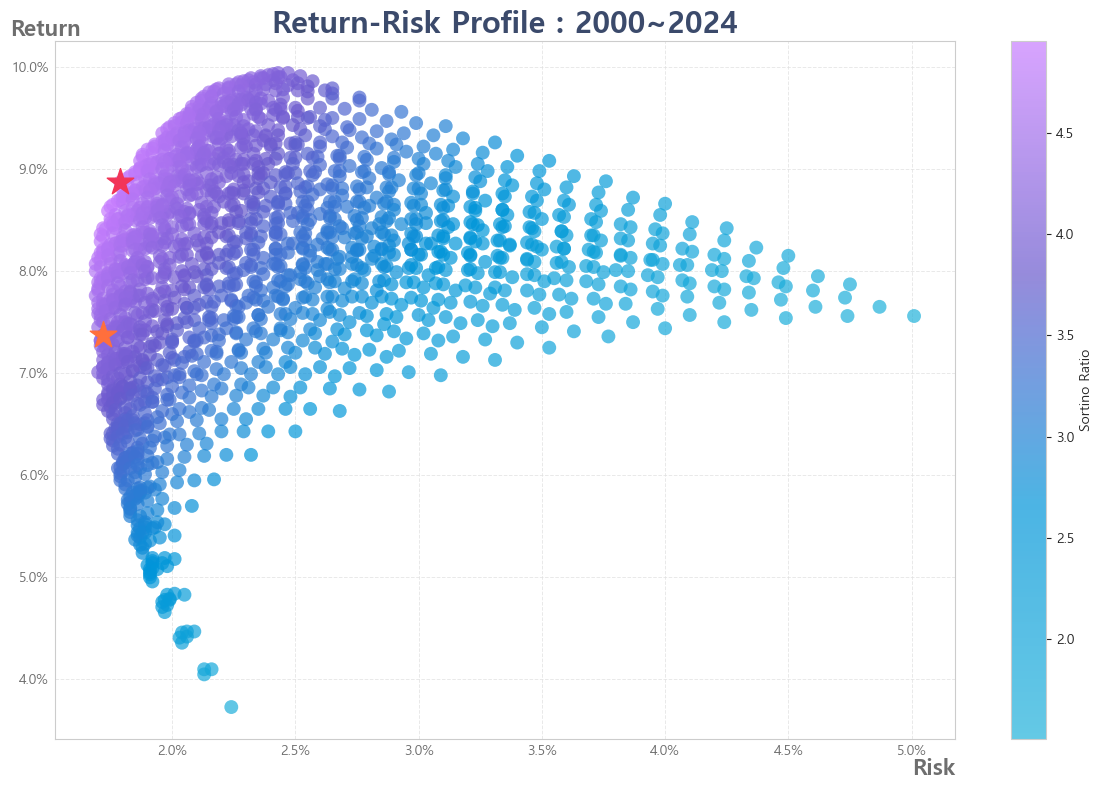

In [11]:
fig, ax = plt.subplots(figsize=figsize)

plot_df = process

x = 'Volatility(Down)'
y = 'Return'

plt.scatter(plot_df[x], plot_df[y], c=process['Sortino Ratio'], marker='o', linewidth=0, alpha=0.7, cmap=custom_cmap, s=100)

# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{round(x, 2)}%"

# X축, Y축에 % 포맷터 적용
plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="x", pad=1)  # X축 눈금 패딩 조정
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 축 설정
plt.title(f"Return-Risk Profile : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.xlabel("Risk", fontsize=16, labelpad=0, fontweight="bold", color=color_around, loc="right")
plt.ylabel("Return", fontsize=16, labelpad=-50, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.colorbar(label='Sortino Ratio')

plt.xticks(fontsize=10, color=color_around)
plt.yticks(fontsize=10, color=color_around)
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

plt.scatter(obtimal[x][0], obtimal[y][0], marker="*", s=400, alpha=1, c = color_norm)
plt.scatter(min_risk[x][0], min_risk[y][0], marker="*", s=400, alpha=1, c = color_sub)

plt.tight_layout()
plt.show()

In [12]:
obtimal

Ticker,QQQ,SCHD,TLT,GOLD,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio
0,0.0,0.4,0.15,0.45,8.87,2.8,1.79,3.16,4.95


In [13]:
min_risk

Ticker,QQQ,SCHD,TLT,GOLD,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio
0,0.0,0.4,0.4,0.2,7.37,2.41,1.72,3.06,4.29


In [15]:
ratio = pd.DataFrame(list(min_risk.values[0][:-5]),
             index=min_risk.columns[:-5], columns=['ratio'])
ratio = list(ratio['ratio'])
result = allocator.cal_rebalancing(dataset_imputed_m, ratio=ratio, rebalancing='m', unit='monthly')

## Report

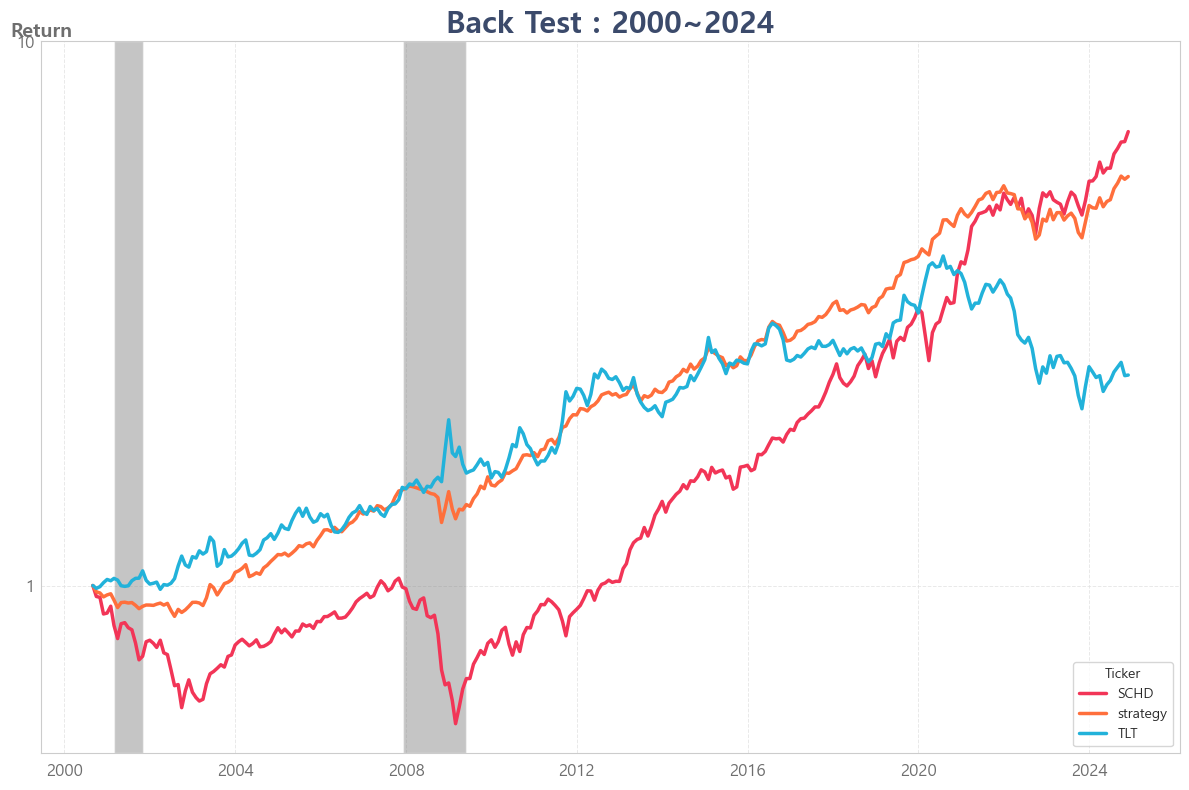

In [16]:
_df = (result/np.array(result)[0])[['SCHD', 'strategy', 'TLT']].reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_sub, color_cont]
lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2.5)
plt.title(f"Back Test : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.yscale('log')
plt.xticks(fontsize=12, color=color_around)
plt.yticks([1, 10], ['1', '10'], fontsize=12, color=color_around)

plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)

# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

In [17]:
## 연수익률
anal_funcs.get_YTD_report(result, 'g')

Ticker,QQQ,SCHD,TLT,GOLD,strategy
Date,,,,,
2001,-40.56,-11.49,-1.96,2.43,-4.29
2002,-46.79,-22.00,11.60,22.09,1.14
2003,40.33,19.94,1.59,17.89,12.68
2004,10.02,7.34,8.35,5.11,7.56
2005,1.55,2.56,8.25,16.72,8.01
2006,6.90,10.83,0.71,20.57,9.13
2007,17.42,3.09,9.81,27.34,10.97
2008,-54.00,-39.86,29.23,5.67,-1.49
2009,43.62,18.26,-24.60,21.47,2.80


In [18]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result, 'a')
MDD

,MDD(%),Date
Ticker,,
QQQ,-79.61,2002-09-30
SCHD,-45.97,2009-02-28
TLT,-47.61,2023-10-31
GOLD,-42.01,2015-12-31
strategy,-20.23,2022-09-30


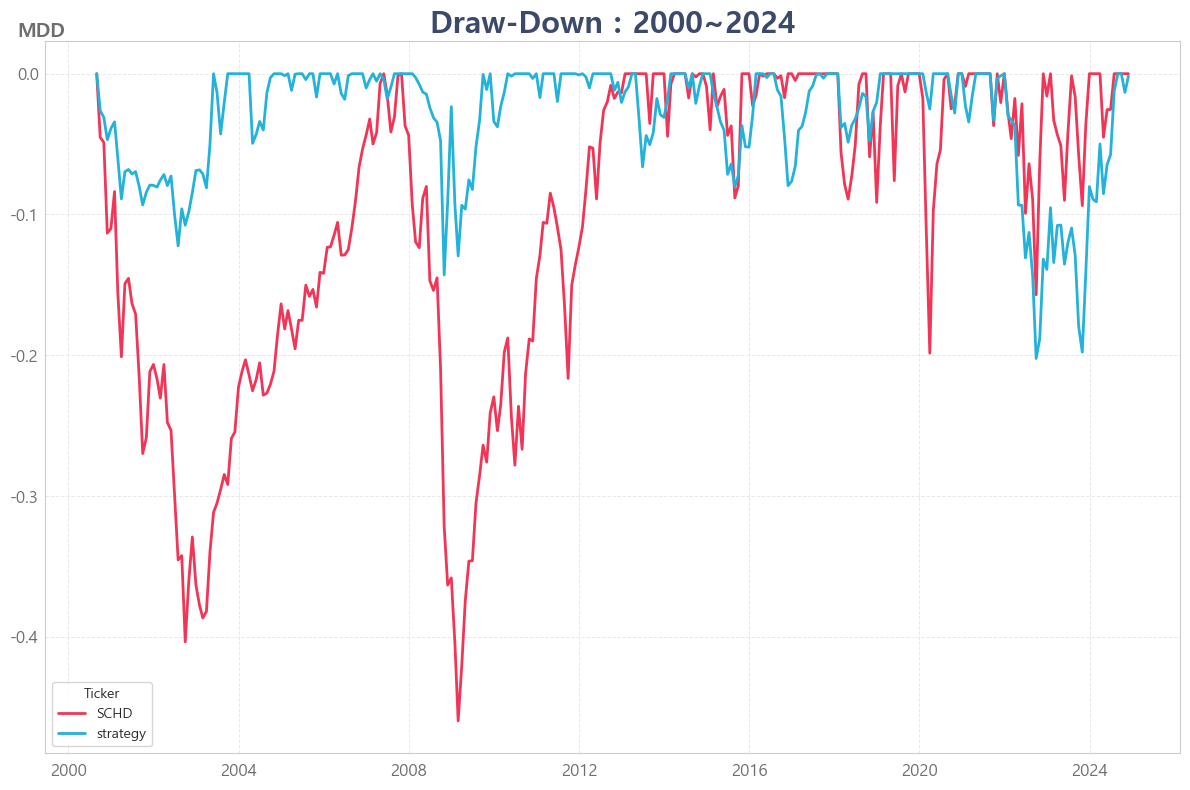

In [26]:
_df = HRR[['SCHD', 'strategy']].dropna().reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_cont]
lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title(f"Draw-Down : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("MDD", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)

# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

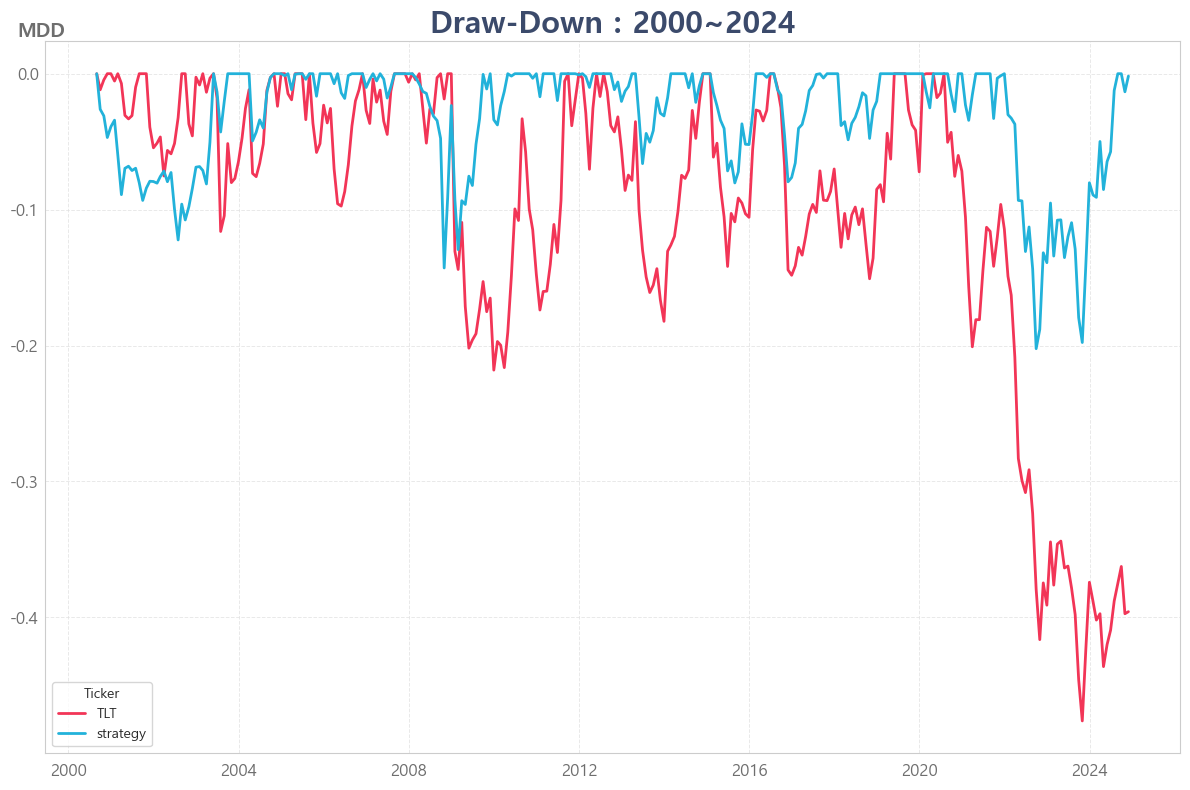

In [27]:
_df = HRR[['TLT', 'strategy']].dropna().reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_cont]
lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title(f"Draw-Down : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("MDD", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)

# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

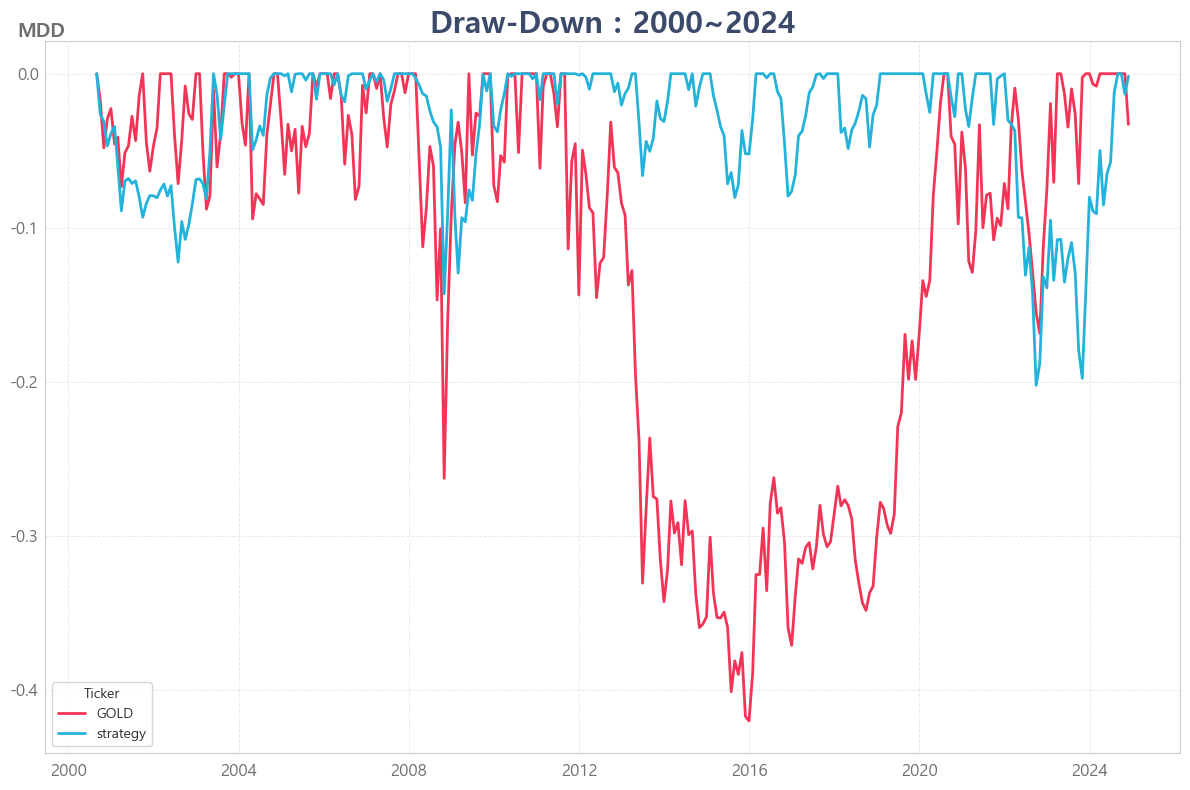

In [28]:
_df = HRR[['GOLD', 'strategy']].dropna().reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_cont]
lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title(f"Draw-Down : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("MDD", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)

# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

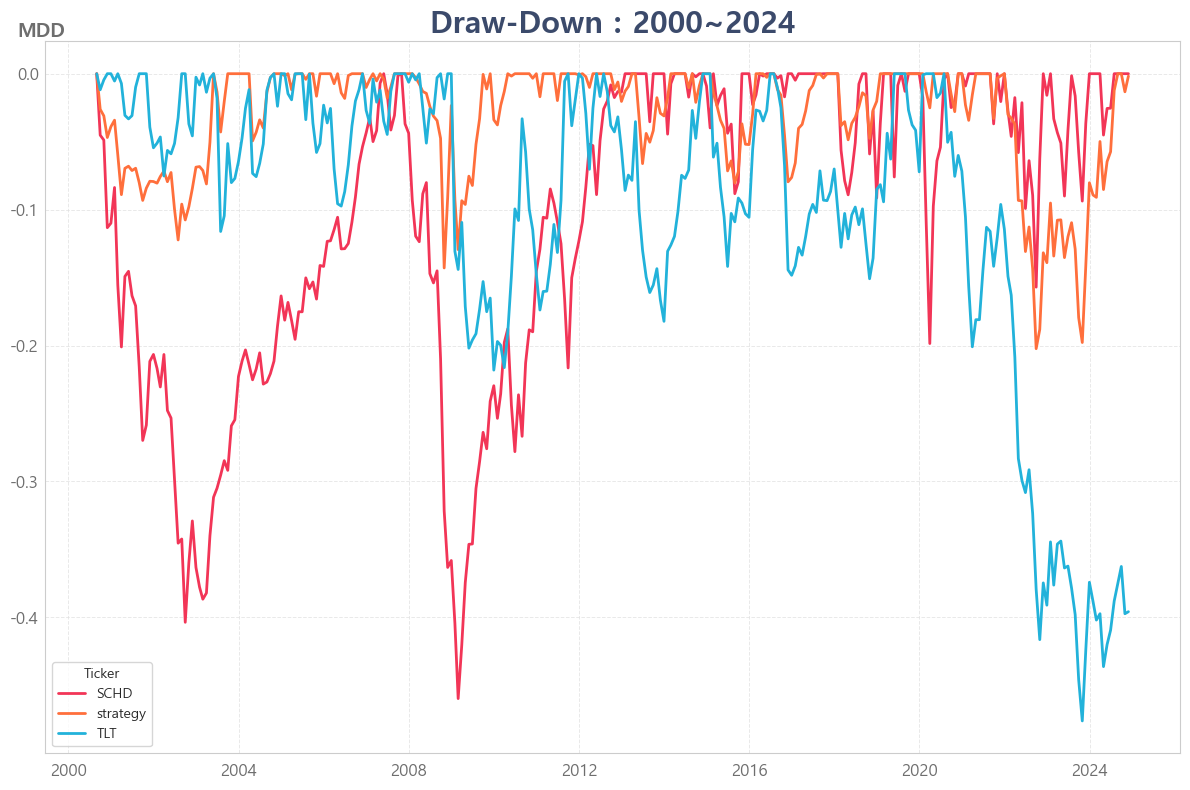

In [19]:
_df = HRR[['SCHD', 'strategy', 'TLT']].dropna().reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_sub, color_cont]
lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title(f"Draw-Down : {dataset_imputed.index[0].year}~{dataset_imputed.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("MDD", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)

# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

###### Rolling

In [20]:
dfs = split_time_series(result, 12*5)

In [21]:
## calculate Rolling Returns
_ls = []
_idx = []
for _df in dfs:
    _ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    _idx.append(_df.index[0])  
res = pd.DataFrame(_ls, columns = _df.columns, index=_idx)

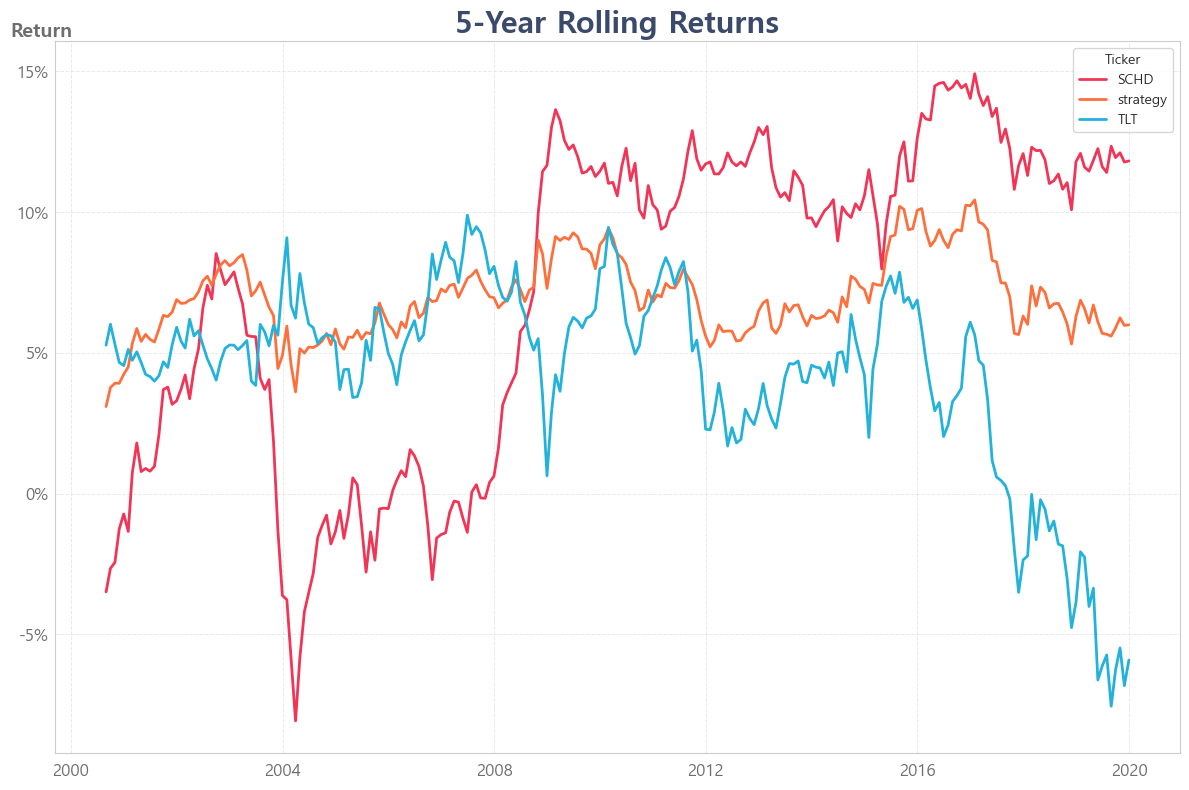

In [33]:
_df = res[['SCHD', 'strategy', 'TLT']].copy().reset_index()
_df = _df.melt(id_vars='index', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_sub, color_cont]
lineplot = sns.lineplot(data=_df, x='index', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title('5-Year Rolling Returns', fontsize=22, fontweight='bold', color=color_basic)
plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)


# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{int(x)}%"
# X축, Y축에 % 포맷터 적용
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

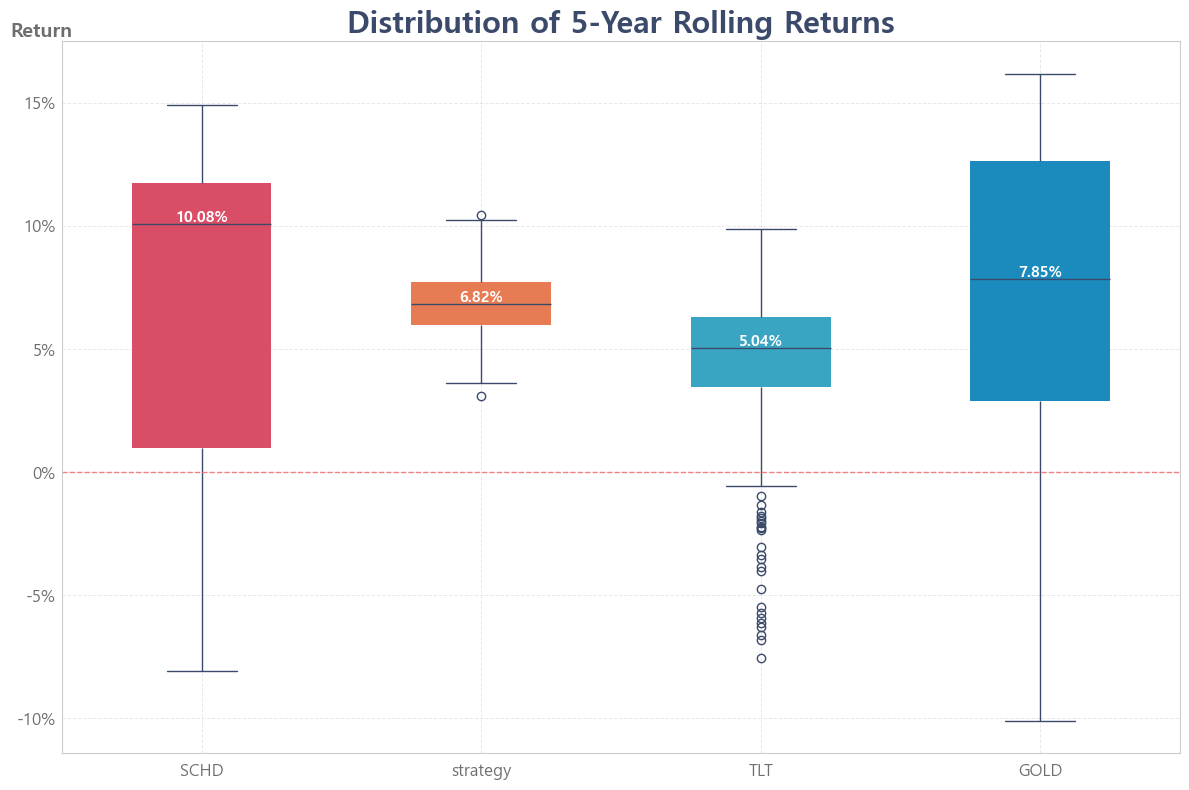

In [22]:
plot_df = res[['SCHD', 'strategy', 'TLT', 'GOLD']].copy()

plt.figure(figsize=figsize)
colors = [color_norm, color_sub, color_cont, color_cont2]
boxplot = sns.boxplot(data=plot_df, palette=colors, width=0.5, linewidth=1, linecolor= color_basic, boxprops=dict(edgecolor="black", linewidth=0))

# 각 요소의 강조
plt.title('Distribution of 5-Year Rolling Returns', fontsize=22, fontweight='bold', color=color_basic)
plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)


# 상자 위에 중앙값 추가
medians = plot_df.median()
for i, median in enumerate(medians):
    plt.text(i, median+0.25, f'{median:.2f}%', ha='center', va="center", fontsize=11,
             color="white", fontweight="bold")


# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{int(x)}%"
# X축, Y축에 % 포맷터 적용
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 보조선 추가
plt.axhline(y=0, color='lightcoral', linestyle='--', linewidth=1)

# 그래프 표시
plt.tight_layout()
plt.show()